# Adaptations to the snowpack evolution function

This notebook is an experimental one, to add features and options to the existing snowpack evolution simulation functions, before deciding which to keep or not.

## Imports and functions

In [1]:
%run little_awk_functions.py
%run parameters.py

In [2]:
def simulate_snowpack_evolution_modif(ds, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                start_accumulation, end_accumulation, start_erosion, end_erosion,
                                jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc_default, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2,
                                met_temp_data=[None], met_time_data=[0],
                                new_snow_ro=150, fit_top_of_snowfall_to_curve=False, erode_several_layers=False):
    '''
    See previous docstrings, with additions: erode_several_layers, 
    '''
    # Initialize arrays to keep track of variables in time
    ro_layer_evolution = []
    depth_evolution = []
    temperature_evolution = []

    if met_temp_data[0] != None:
        tsfc = float(met_temp_data[0])
    else:
        tsfc = tsfc_default

    # Initialize indices of next accumulation/erosion events coming up (updated when their time is past)
    accumulation_index = 0
    erosion_index = 0
    temperature_index = 0
    
    for i in range(nb_iterations):

        if temperature_index<len(met_temp_data) and met_time_data[temperature_index]!=None and i*dt>=met_time_data[temperature_index]:
            if met_temp_data[temperature_index] != None:
                tsfc = float(met_temp_data[temperature_index])
            temperature_index += 1

        if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
            if fit_top_of_snowfall_to_curve:
                snow_depth_total = sum(dy_snow[i] for i in range(0,jj))
                ddepth = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation[accumulation_index])) - snow_depth_total
            else:
                ddepth = get_change_in_snow_depth(ds, start_accumulation, end_accumulation, accumulation_index, x_sel, y_sel)
            ro_layer[jj] = new_snow_ro
            t_old[jj] = tsfc
            dy_snow[jj] = ddepth
            age_layers[jj] = (nb_iterations-i) * dt           # age in seconds at end of simulation
            if t_old[jj] <= 0:
                melt_flag[jj] = 0
            else:
                melt_flag[jj] = 1
            jj += 1
            accumulation_index += 1
    
        if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:
            ddepth = get_change_in_snow_depth(ds, start_erosion, end_erosion, erosion_index, x_sel, y_sel)
            erosion_index += 1
            if erode_several_layers:
                while jj>0 and dy_snow[jj-1] <= ddepth:
                    ddepth -= dy_snow[jj-1]
                    jj -= 1
                    dy_snow[jj] = 0
                    ro_layer[jj] = 0
                    t_old[jj] = 0
                    age_layers[jj] = 0
                    melt_flag[jj] = 0
            if jj>0:
                if dy_snow[jj-1] > ddepth:
                    dy_snow[jj-1] = dy_snow[jj-1] - ddepth
                else:
                    jj -= 1
                    dy_snow[jj] = 0
                    ro_layer[jj] = 0
                    t_old[jj] = 0
                    age_layers[jj] = 0
                    melt_flag[jj] = 0
    
        # Update layers' parameters
        ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, ro_ice, t_old, jj, dy_snow, a1, a2)
        t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, tf, dy_snow, melt_flag)
    
        # Keep track of events
        ro_layer_evolution.append(ro_layer)
        depth_evolution.append(dy_snow)
        temperature_evolution.append(t_old)
        
    return(ro_layer_evolution, depth_evolution, temperature_evolution)

## Define dataset and clean data

In [3]:
# Pre-processing to get clean data

data_set_used = xr.open_dataset('snow_pit_1_filled.nc')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)
median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].isel(x=x_sel, y=y_sel).dropna('time').min()


---> Median filtering in space with a window [7, 11]
---> Median filtering in time with a window of 11


## Get timing values

In [4]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

In [5]:
# Get timing of events

results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


## Simulate the snowpack

In [6]:
# Simulate the snowpack

snowpack = simulate_snowpack_evolution_modif(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp,
                                       met_time_data=met_time, new_snow_ro=simul_new_snow_ro,
                                       fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve, erode_several_layers=True)

ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]


In [8]:
# Simulate the snowpack

snowpack2 = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp,
                                       met_time_data=met_time, new_snow_ro=simul_new_snow_ro,
                                       fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)

ro_layer_evolution_orig, depth_evolution_orig, temperature_evolution_orig = snowpack2[0], snowpack2[1], snowpack2[2]

## Plot results

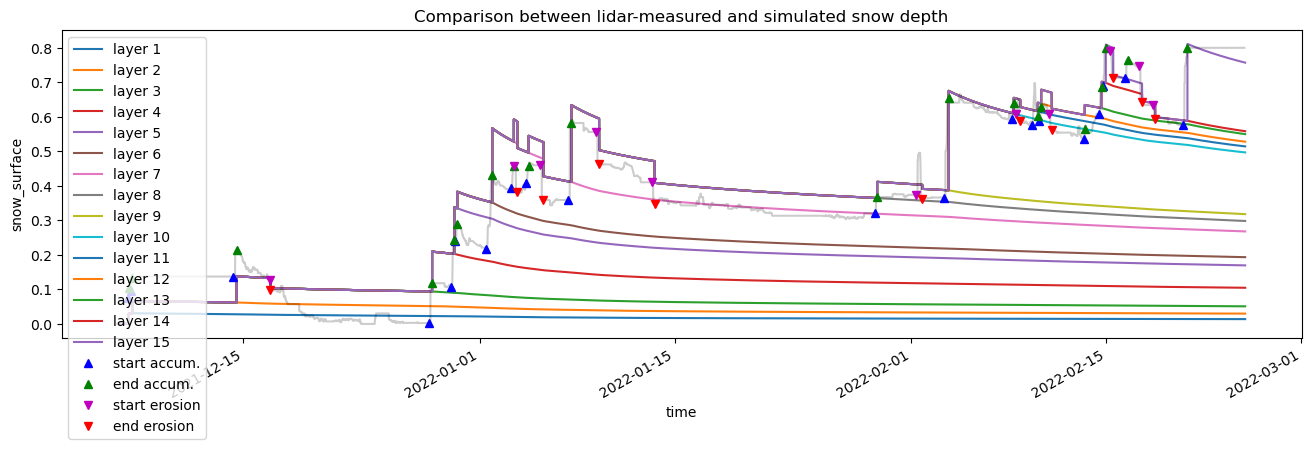

()

In [12]:
plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution, 15, pd.to_datetime('2021-12-06T00:00'), dt, nb_iterations,
                      start_accumulation, end_accumulation, start_erosion, end_erosion, my_figsize=(16, 4), save_file=False)

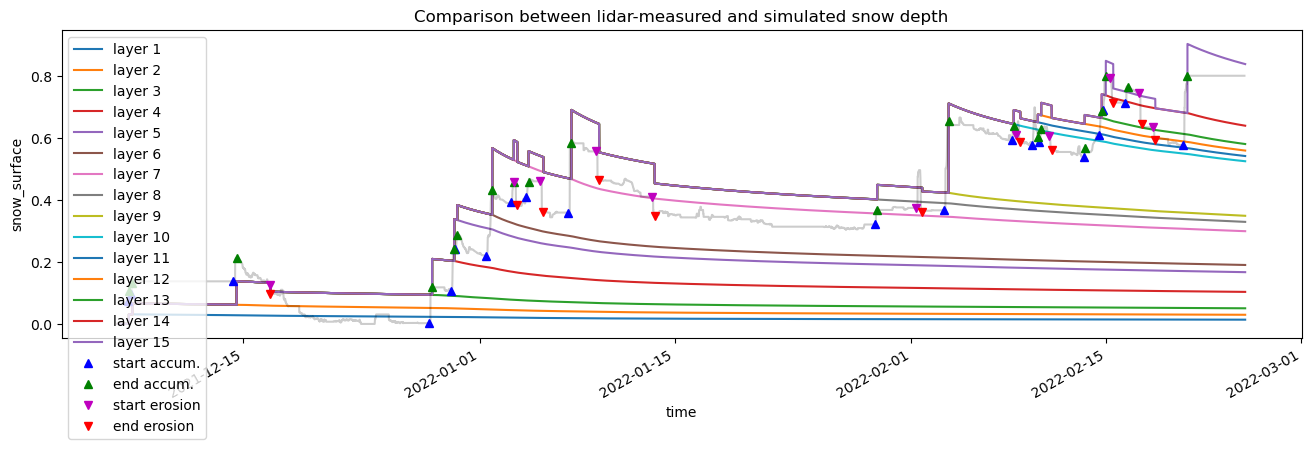

()

In [13]:
plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution_orig, 15, pd.to_datetime('2021-12-06T00:00'), dt, nb_iterations,
                      start_accumulation, end_accumulation, start_erosion, end_erosion, my_figsize=(16, 4), save_file=False)